# Déployez un modèle dans le cloud

## 1. Préambule

### 1.1 Objectif global du projet

La start-up fictive **Fruits!**, active dans le secteur de l’AgriTech, souhaite développer une application mobile capable de reconnaître automatiquement des fruits à partir d’une photo prise par un utilisateur.

L’objectif de cette première phase est de construire une **chaîne de traitement Big Data** capable :
- de charger les images,
- d’extraire automatiquement des vecteurs de caractéristiques via **transfert learning**,
- de les sauvegarder dans un format structuré pour des traitements en aval (PCA, clustering, etc.).

---

### 1.2 Objectif de ce notebook

Ce notebook a pour but de **valider la chaîne de traitement en local** :
- en **utilisant PySpark** pour simuler un environnement distribué,
- en **appliquant un modèle MobileNetV2** via **transfert learning** pour extraire les features,
- en **utilisant toutes les étiquettes** présentes dans le dossier `fruits-360_dataset/fruits-360/Training`,
- et en **sauvegardant les résultats** au format `parquet`.

Cette version locale nous permettra ensuite de passer à une version **cloud distribuée (AWS EMR + S3)**.

---

### 1.3 Structure du notebook

Ce projet se structure comme suit :

1. **Préambule** : objectif, contexte et plan.
2. **Environnement de travail** : imports, paths, SparkSession.
3. **Chargement des données** : lecture binaire des images et extraction des labels.
4. **Préparation du modèle MobileNetV2** (transfert learning).
5. **Extraction des vecteurs de caractéristiques avec Pandas UDF**.
6. **Sauvegarde des résultats au format `parquet`**.
7. **Réduction de dimension + visualisation**.
8. **Conclusion** et perspective cloud.

---

## 2. Environnement de travail

### 2.1 Imports des librairies

Nous importons ici les bibliothèques nécessaires à notre projet local.  
Ces bibliothèques sont compatibles avec un futur déploiement sur cluster Spark via AWS EMR.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import io
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

### 2.2 Définition des chemins d’accès

Dans cette version locale, nous utilisons un extrait du dataset officiel Fruits 360, téléchargé et placé dans le dossier fruits-360_dataset/fruits-360/Training.

Les images seront chargées depuis ce répertoire, et les résultats seront enregistrés localement dans un dossier Results_Local.

> 🧠 Le dataset contient des sous-dossiers par classe de fruit (ex : Apple Braeburn, Banana, etc.), ce qui permet d’extraire automatiquement les labels à partir du chemin d’accès.

> 💡 Adaptation WSL : Le disque C: de Windows est monté sous /mnt/c/ dans WSL

In [3]:
# Chemins pour WSL (converti depuis C:/...)
# Exemple : dossier créé localement avec 10 images par classe
PATH_ROOT = "/content/drive/MyDrive/projet8"
PATH_DATA = os.path.join(PATH_ROOT, "Training_subset")
PATH_RESULTS = os.path.join(PATH_ROOT, "Results_Colab")

# Vérification de l'existence du dossier de données
assert os.path.exists(PATH_DATA), f"❌ Le dossier n'existe pas : {PATH_DATA}"

print("📂 Dossier de données :", PATH_DATA)
print("📁 Dossier de sortie :", PATH_RESULTS)

📂 Dossier de données : /content/drive/MyDrive/projet8/Training_subset
📁 Dossier de sortie : /content/drive/MyDrive/projet8/Results_Colab


In [4]:
import os

# Dossier contenant les classes
label_folders = os.listdir(PATH_DATA)

# Filtrer uniquement les dossiers (au cas où il y aurait des fichiers)
label_folders = [f for f in label_folders if os.path.isdir(os.path.join(PATH_DATA, f))]

# Affichage
print(f"🍇 Nombre de classes de fruits : {len(label_folders)}")
print("📁 Exemples de classes :", label_folders[:10])

🍇 Nombre de classes de fruits : 131
📁 Exemples de classes : ['Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 2', 'Apple Golden 2', 'Apple Golden 1', 'Apple Braeburn', 'Apple Golden 3', 'Apple Crimson Snow', 'Apple Red 3', 'Apple Red 1']


### 2.3 Création de la SparkSession

Nous créons une session Spark nommée `Fruits_Local`.  
Dans ce mode, Spark est exécuté **en local** mais permet déjà de simuler un environnement distribué.

In [5]:
!pip install pyspark

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Fruits_Colab") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext
print("✅ SparkSession active :", spark.version)

✅ SparkSession active : 3.5.1


## 3. Chargement et préparation des données
### 3.1 Chargement des images

Nous chargeons les images au format binaire à partir du répertoire Training du dataset Fruits 360.

Spark lit l’ensemble des fichiers .jpg de manière récursive dans les sous-dossiers, où chaque sous-dossier représente une classe de fruit (label).


In [7]:
from pyspark.sql.functions import col, element_at, split

# Charger toutes les images
images = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(f"file://{PATH_DATA}")

images.printSchema()
images.show(5)

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/dri...|2021-09-12 17:27:00|  7434|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:52|  7262|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:52|  7233|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:52|  7230|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:52|  7214|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



### 3.2 Ajout des labels

Nous extrayons le nom du dossier parent (qui correspond à la classe de fruit) pour l’ajouter en tant que label à chaque image.

In [8]:
images = images.withColumn(
    "label",
    element_at(split(col("path"), "/"), -2)
)

images.select("path", "label").show(5, truncate=False)

+------------------------------------------------------------------------------+--------------+
|path                                                                          |label         |
+------------------------------------------------------------------------------+--------------+
|file:/content/drive/MyDrive/projet8/Training_subset/Raspberry/179_100.jpg     |Raspberry     |
|file:/content/drive/MyDrive/projet8/Training_subset/Pineapple Mini/165_100.jpg|Pineapple Mini|
|file:/content/drive/MyDrive/projet8/Training_subset/Pineapple Mini/106_100.jpg|Pineapple Mini|
|file:/content/drive/MyDrive/projet8/Training_subset/Pineapple Mini/110_100.jpg|Pineapple Mini|
|file:/content/drive/MyDrive/projet8/Training_subset/Pineapple Mini/193_100.jpg|Pineapple Mini|
+------------------------------------------------------------------------------+--------------+
only showing top 5 rows



## 4. Préparation du modèle MobileNetV2 (transfert learning)
### 4.1 Chargement du modèle MobileNetV2

Nous appliquons ici la technique du transfert learning, en important le modèle MobileNetV2 pré-entraîné sur ImageNet.
Nous supprimons la dernière couche (Softmax) pour ne conserver que le vecteur de caractéristiques de dimension (1, 1, 1280).

In [9]:
# Chargement du modèle MobileNetV2 pré-entraîné
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Suppression de la couche de classification finale (Softmax)
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Résumé du modèle pour vérifier la sortie attendue (1280)
new_model.summary()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### 4.2 Broadcast des poids pour Spark

Les poids du modèle sont chargés une seule fois sur le driver, puis diffusés à l’ensemble des workers avec SparkContext.broadcast.

In [10]:
# Diffusion des poids vers les workers
broadcast_weights = sc.broadcast(new_model.get_weights())

### 4.3 Définition d’une fonction model_fn()

Cette fonction est appelée dans les pandas UDF pour recharger le modèle dans chaque worker Spark.

In [11]:
def model_fn():
    """
    Retourne une instance de MobileNetV2 sans la couche finale,
    avec les poids broadcastés rechargés.
    """
    model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

## 5. Extraction des vecteurs de caractéristiques avec Pandas UDF
### 5.1 Prétraitement des images (redimensionnement + normalisation)

Avant de les passer dans MobileNetV2, les images doivent :

- être redimensionnées en 224x224 pixels,

- converties en tableau NumPy,

- normalisées avec preprocess_input().

In [12]:
def preprocess(content):
    """
    Convertit une image binaire en tableau NumPy normalisé pour MobileNetV2.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

### 5.2 Application du modèle sur une série d’images

On applique le modèle à une série d’images pour en extraire un vecteur par image.

In [13]:
def featurize_series(model, content_series):
    """
    Applique MobileNetV2 à une série d’images brutes.
    Retourne une série de vecteurs de caractéristiques.
    """
    input_array = np.stack(content_series.map(preprocess))
    preds = model.predict(input_array)
    # Aplatir les tenseurs pour les stocker proprement dans un DataFrame Spark
    return pd.Series([p.flatten() for p in preds])

### 5.3 Définition d’un pandas_udf Spark

Nous utilisons ici un UDF avec itérateur (SCALAR_ITER) qui permet de :

- ne charger le modèle qu’une seule fois par partition Spark,

- appliquer le modèle à des lots d’images.

In [14]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    Pandas UDF distribué pour transformer les images en vecteurs.
    """
    model = model_fn()  # Charge MobileNetV2 sans la dernière couche
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### 5.4 Application du UDF sur les images

On applique maintenant ce UDF à notre DataFrame Spark pour créer un DataFrame features_df contenant :

- le chemin de l’image,

- son label (classe de fruit),

- son vecteur de caractéristiques (1280 valeurs).

In [15]:
features_df = images.repartition(20).select(
    col("path"),
    col("label"),
    featurize_udf("content").alias("features")
)

In [16]:
features_df.show(3, truncate=False)

+-----------------------------------------------------------------------------+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 6. Sauvegarde des résultats au format parquet

Après avoir généré les vecteurs de caractéristiques avec MobileNetV2 pour chaque image, nous enregistrons le DataFrame features_df dans un fichier au format Parquet. Ce format est optimisé pour le stockage structuré et est compatible avec les traitements distribués en aval (ex : PCA, clustering, etc.).

💾 Le fichier sera écrit dans le dossier défini plus tôt : PATH_RESULTS.

In [17]:
# 6.1 Paramètre de sauvegarde
SAVE_PARQUET = False

# 6.2 Affichage du chemin cible
print("📁 Enregistrement dans :", PATH_RESULTS)

# 6.3 Sauvegarde conditionnelle
if SAVE_PARQUET:
    # Enregistrement du DataFrame Spark au format Parquet
    print("📦 Enregistrement du fichier Parquet...")
    features_df.write.mode("overwrite").parquet(PATH_RESULTS)
    print("✅ Fichier Parquet écrit avec succès.")
else:
    print("⚠️ Sauvegarde désactivée — aucun fichier écrit.")


📁 Enregistrement dans : /content/drive/MyDrive/projet8/Results_Colab
⚠️ Sauvegarde désactivée — aucun fichier écrit.


## 🧪 Partie 7 – PCA avec PySpark MLlib (compatible EMR)

### 7.1 Conversion array<float> → VectorUDT pour MLlib

In [18]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT

# UDF pour convertir une liste Python en vecteur dense MLlib
to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# Ajout d'une colonne "features_vector" au format VectorUDT
vector_df = features_df.withColumn("features_vector", to_vector_udf("features"))

### 7.2 PCA via PySpark MLlib

Ajouter une standardisation avant l'ACP

In [19]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA as PCAml

scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(vector_df)
scaled_df = scaler_model.transform(vector_df)

# Ensuite, fais la PCA sur scaled_features
pca = PCAml(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)
pca_result_df = pca_model.transform(scaled_df)

### 7.3 Extraction des composantes via .values[0] et .values[1]

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

def vector_to_array_udf(v):
    return v.toArray().tolist()

to_array_udf = udf(vector_to_array_udf, ArrayType(FloatType()))

pca_result_df = pca_result_df.withColumn("pca_array", to_array_udf("pca_features"))

In [24]:
# Extraction des deux premières composantes
pca_result_df = (
    pca_result_df
    .withColumn("pca1", col("pca_array")[0])
    .withColumn("pca2", col("pca_array")[1])
)

### 7.4 Visualisation (conversion Pandas uniquement pour affichage)

<ipython-input-25-97916d0b65cf>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


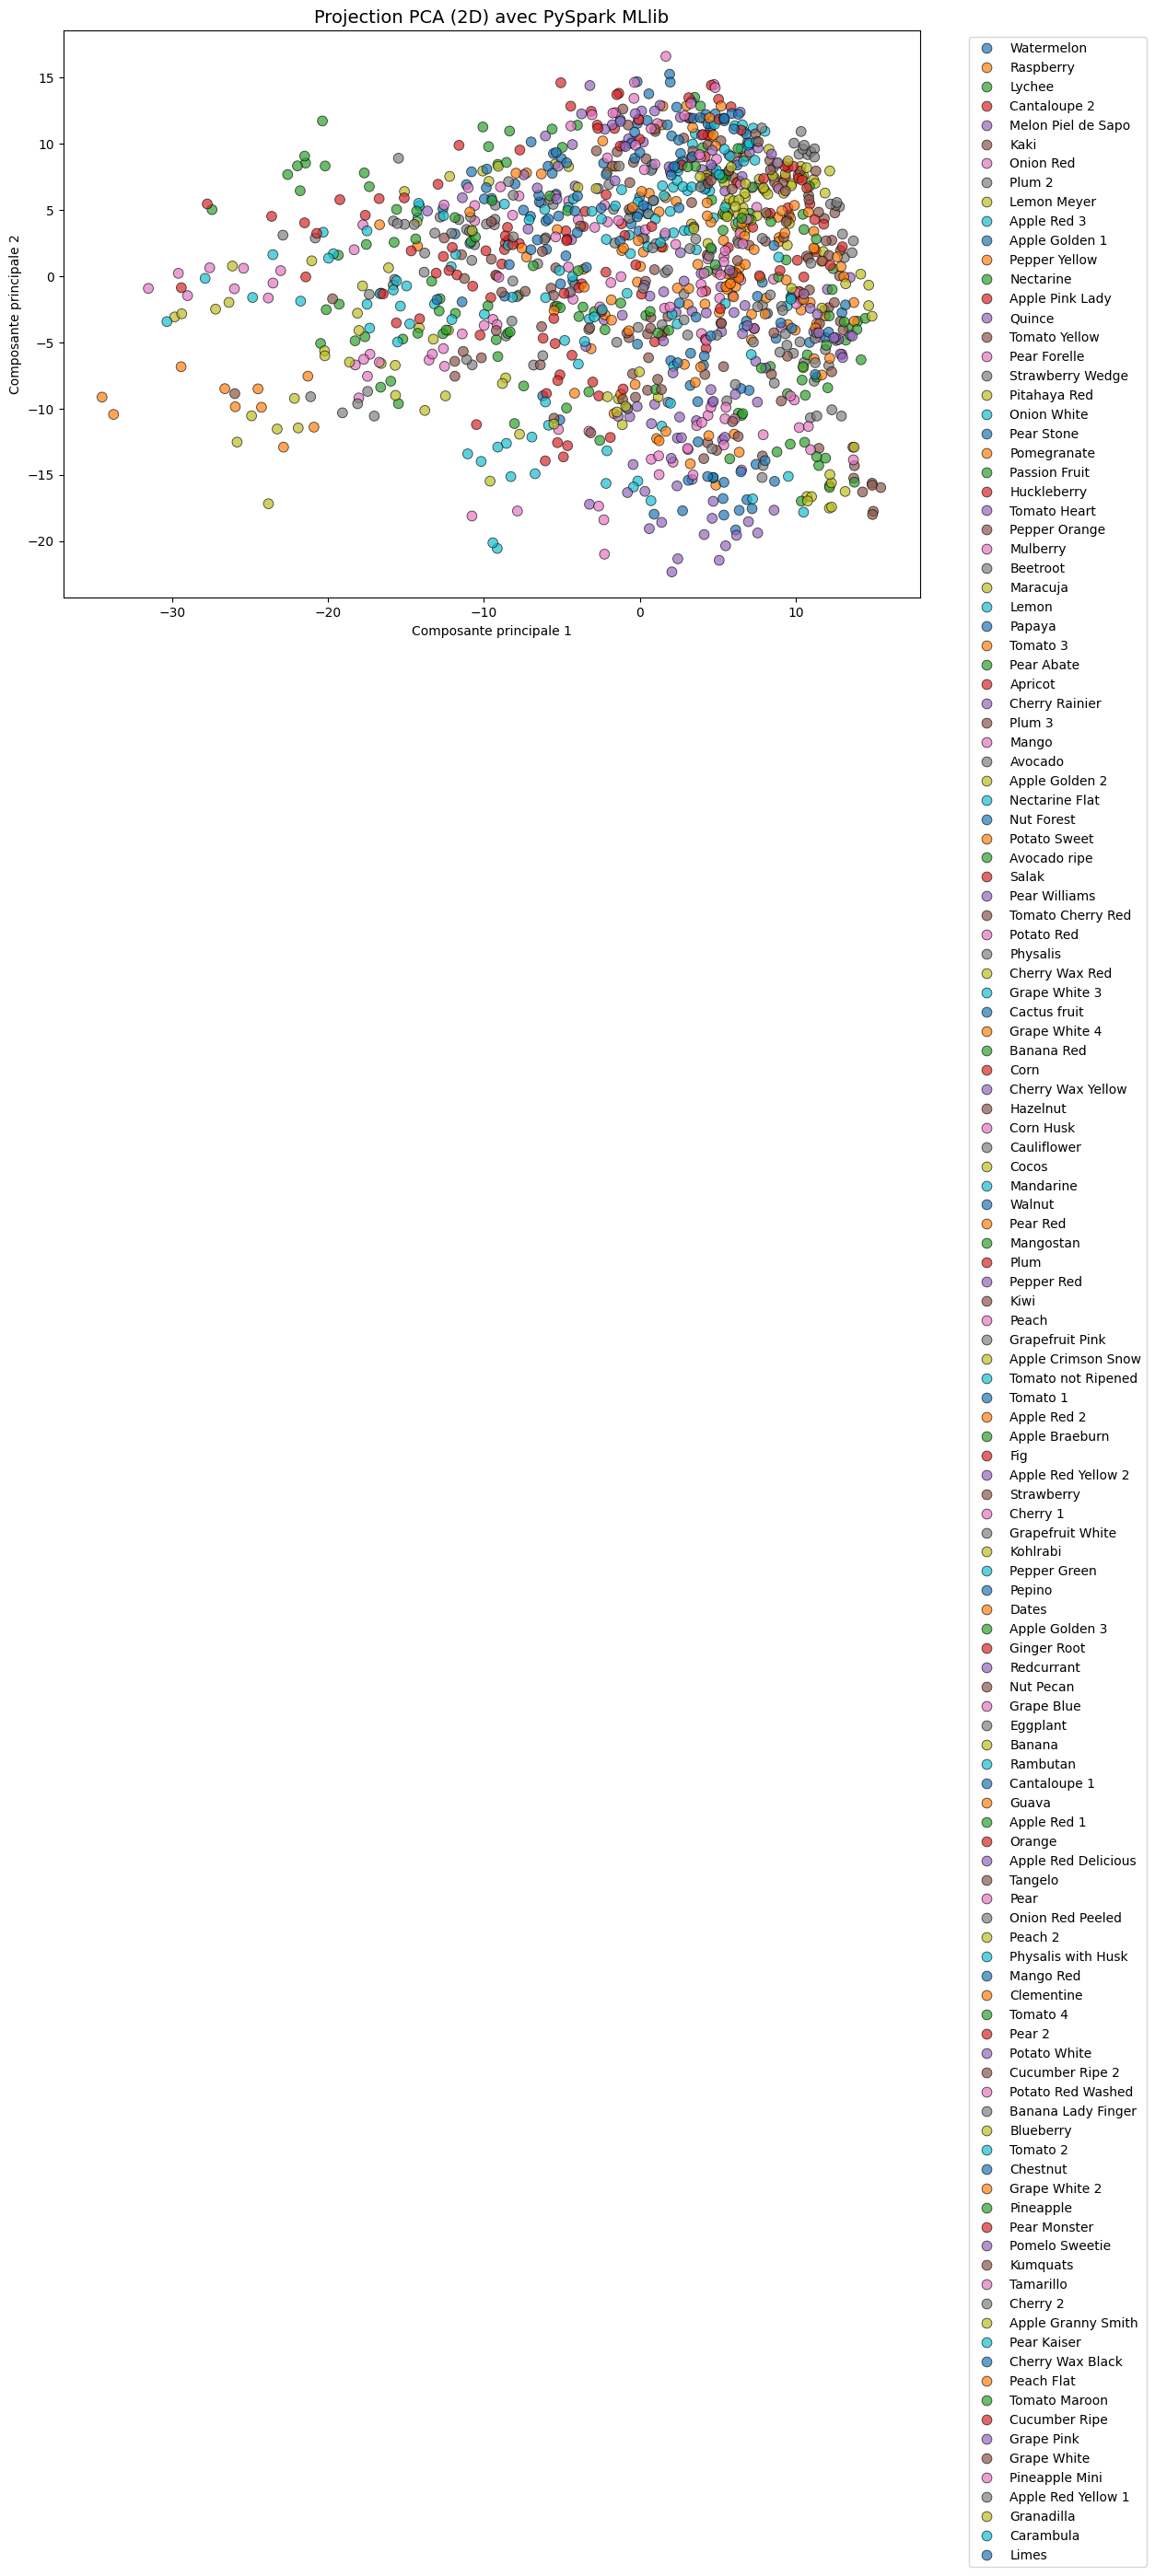

In [25]:
plot_df = pca_result_df.select("label", "pca1", "pca2").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="pca1", y="pca2", hue="label", data=plot_df,
    palette="tab10", s=60, alpha=0.7, edgecolor="k"
)
plt.title("Projection PCA (2D) avec PySpark MLlib", fontsize=14)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 8. Conclusion et perspectives

Dans ce projet, nous avons mis en place une chaîne de traitement Big Data distribuée pour analyser automatiquement des images de fruits à l’aide de PySpark et du transfert learning avec MobileNetV2.

✅ Résultats obtenus :

- Chargement et lecture de plus de 140 classes de fruits depuis le dataset Fruits-360.

- Application de MobileNetV2 pour extraire des vecteurs de caractéristiques (1280-d).

- Réduction de la dimension via une Analyse en Composantes Principales (PCA) à 2D pour visualisation.

- Affichage graphique de la distribution des fruits selon leurs similarités visuelles.

🚀 Perspectives à venir :

- Déploiement du pipeline sur un cluster Spark avec AWS EMR, pour traiter l’ensemble du dataset complet.

- Ajout d’un clustering non supervisé (KMeans) pour découvrir automatiquement des regroupements de fruits similaires.

- Intégration d’un modèle de classification supervisé pour prédire la classe d’un fruit à partir de ses features.

- Création d’un API REST ou d’une interface mobile pour permettre la reconnaissance en temps réel.